**Import Libraries**

In [1]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

Load the Metadata

In [2]:
metadata_path = 'UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadata_path)
print(metadata.head())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


**Basic EDA - Class Distribution**

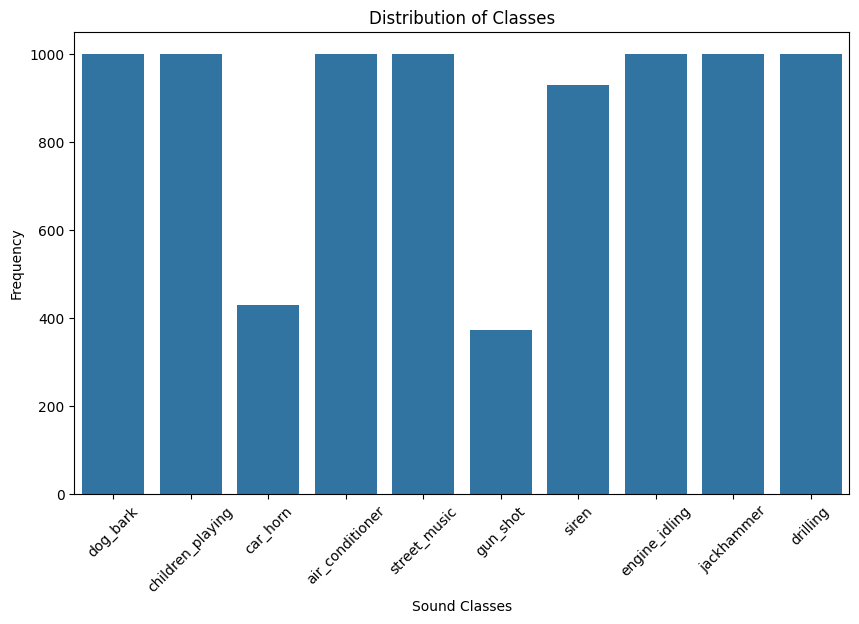

In [3]:

plt.figure(figsize=(10, 6))
sns.countplot(data=metadata, x='class')
plt.title('Distribution of Classes')
plt.xlabel('Sound Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


**Check for Missing Data**

In [4]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:

metadata.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

**Audio Properties Examination**

In [6]:

def get_audio_properties(file_path):
    try:
        
        audio, sample_rate = librosa.load(file_path)
        return {
            'sample_rate': sample_rate,
            'duration': librosa.get_duration(y=audio, sr=sample_rate),
            'samples': len(audio)
        }
    except Exception as e:
        print("Error encountered while parsing file: ", file_path, e)
        return None

import os


sample_file_path = os.path.join("UrbanSound8K/audio", "fold5", "100032-3-0-0.wav") 
if os.path.exists(sample_file_path):
    audio_properties = get_audio_properties(sample_file_path)
    print(audio_properties)
else:
    print("File not found:", sample_file_path)


{'sample_rate': 22050, 'duration': 0.31755102040816324, 'samples': 7002}


Plot Waveforms of Different Classes

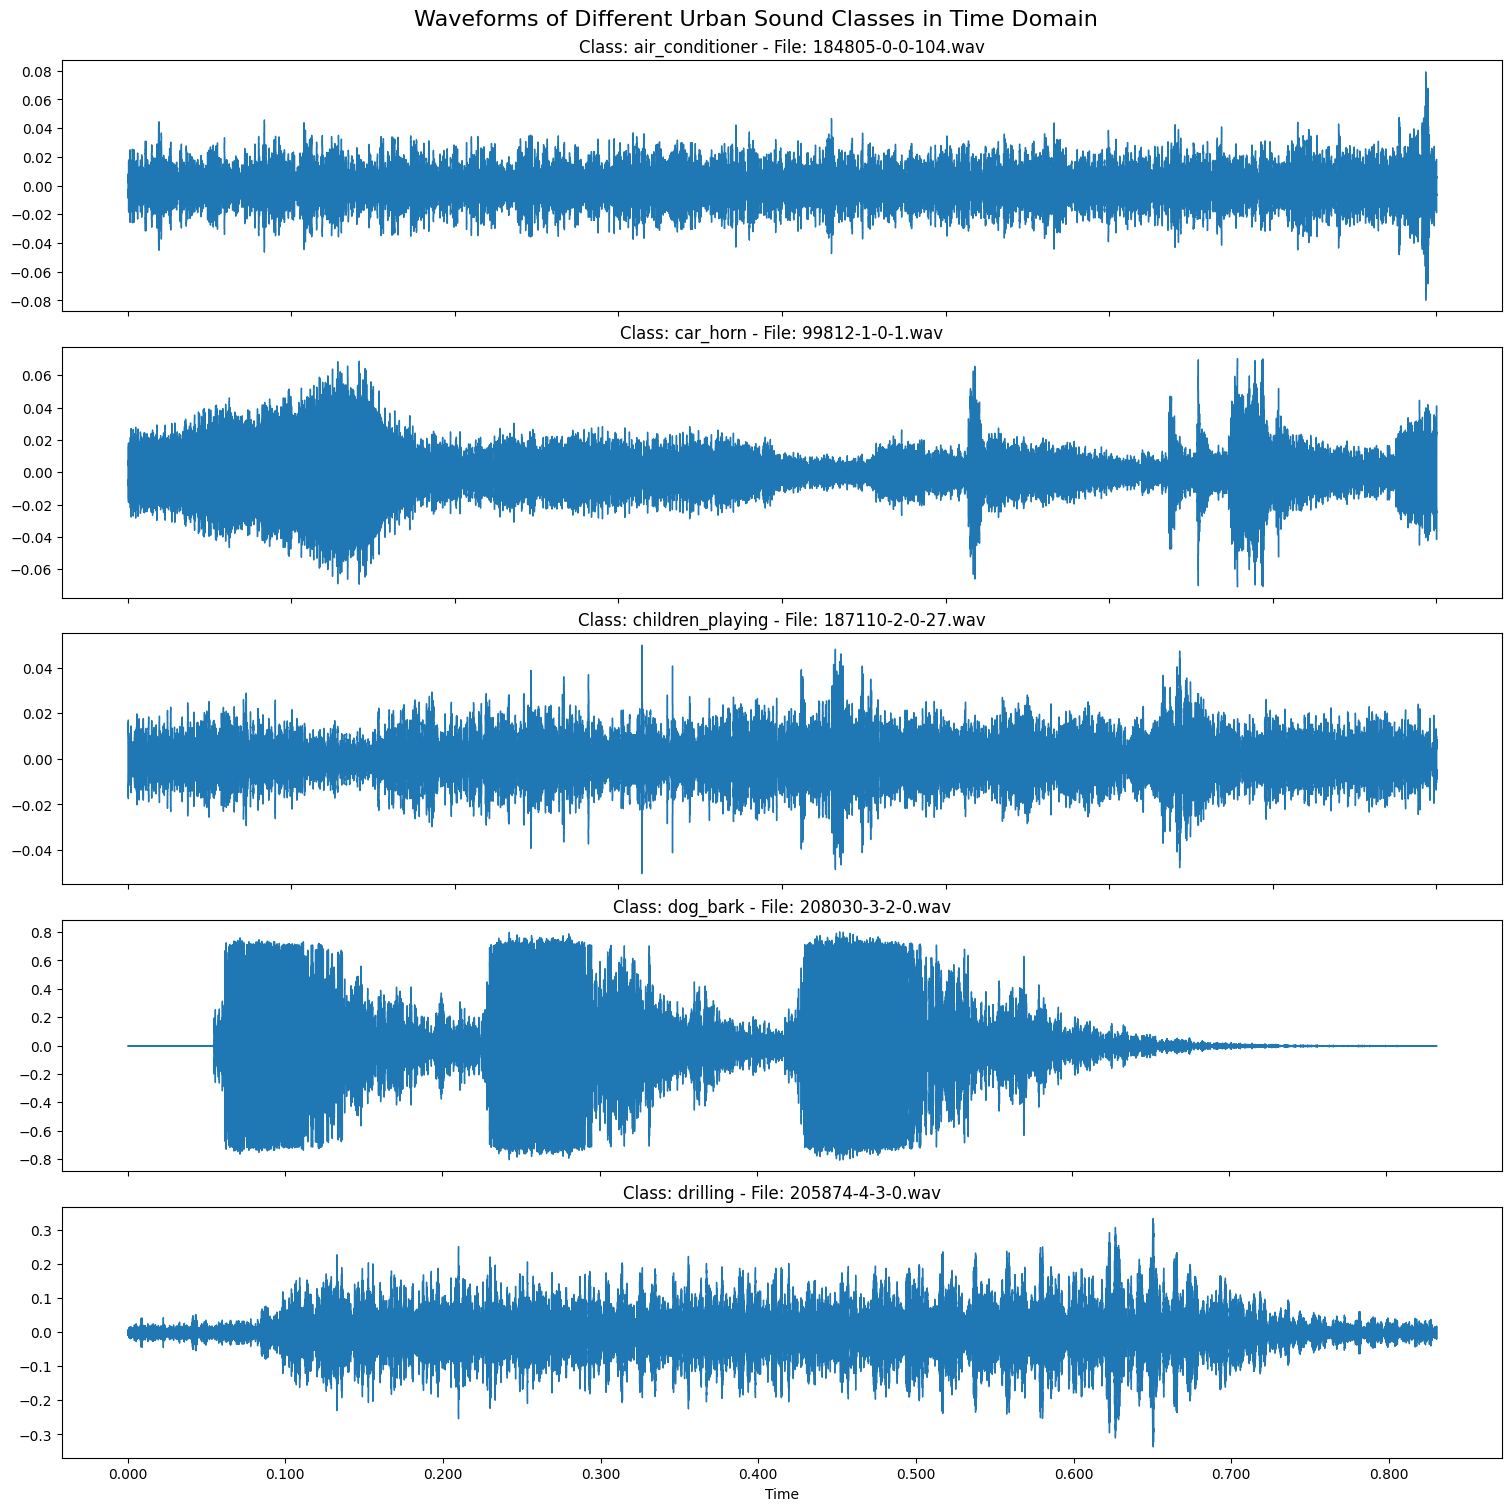

In [7]:
import matplotlib.pyplot as plt
import librosa.display

def plot_waveforms(num_samples=5):
    fig, axs = plt.subplots(num_samples, figsize=(15, 15), constrained_layout=True)
    fig.suptitle('Waveforms of Different Urban Sound Classes in Time Domain', fontsize=16)

    for i, (class_name, group) in enumerate(metadata.groupby('class')):
        if i >= num_samples:
            break
        sample_data = group.sample(n=1, random_state=42)  
        for index, row in sample_data.iterrows():
            file_path = os.path.join('UrbanSound8K/audio', 'fold' + str(row['fold']), row['slice_file_name'])
            audio, sample_rate = librosa.load(file_path)
            ax = axs[i]
            librosa.display.waveshow(audio, sr=sample_rate, ax=ax)
            ax.set_title(f"Class: {row['class']} - File: {row['slice_file_name']}")
            ax.label_outer()

plot_waveforms()


Data Preprocessing

In [8]:
import numpy as np
import pandas as pd
import librosa
import os


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


MFCC

In [9]:
def extract_features(file_path, n_mfcc=40, hop_length=512, n_fft=2048, resample_rate=44100):
    try:
        audio, sample_rate = librosa.load(file_path, sr=resample_rate)  # Use the original sample rate
        if len(audio) < n_fft:  # Adjust n_fft for short audio files
            n_fft = len(audio)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfccs_mean = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, error: {e}")
        return None
    return mfccs_mean

def process_audio_files(metadata):
    features = []
    for index, row in metadata.iterrows():
        file_name = os.path.join('UrbanSound8K/audio', f'fold{row["fold"]}', row["slice_file_name"])
        class_label = row["class"]
        data = extract_features(file_name)
        if data is not None:
            features.append([data, class_label])
    return pd.DataFrame(features, columns=['feature', 'class_label'])


In [10]:
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
featuresdf = process_audio_files(metadata)

In [11]:
featuresdf.head()

,feature,class_label
0,"[-275.91843, 119.49279, -98.21178, -66.51514, ...",dog_bark
1,"[-500.9084, 185.10641, -86.53282, 49.85885, 9....",children_playing
2,"[-531.1953, 186.93994, -70.34916, 40.429245, 9...",children_playing
3,"[-476.78442, 160.33328, -62.952843, 50.75117, ...",children_playing
4,"[-521.2447, 185.39265, -81.95047, 46.47355, 11...",children_playing


Encode Labels

In [12]:

le = LabelEncoder()
featuresdf['class_label'] = le.fit_transform(featuresdf['class_label'])


X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())


In [13]:
featuresdf.feature.tolist()

[array([-2.7591843e+02,  1.1949279e+02, -9.8211777e+01, -6.6515137e+01,
        -4.2606049e+01,  5.0506461e-01, -2.8330936e+01, -5.7468672e+00,
         9.9927874e+00,  4.7954125e+00,  1.5461892e+01, -6.9880471e-02,
        -2.8426731e+00, -1.7041117e+00, -9.8159323e+00,  1.4937593e-02,
         3.0073469e+00,  1.2117919e+00, -5.6431236e+00, -1.0540114e+01,
        -6.1291056e+00, -1.1030781e+00,  3.9834827e-01,  4.2682123e+00,
        -5.9305582e+00, -9.3804321e+00,  2.1611426e+00,  4.0487351e+00,
        -6.0633588e+00, -2.4436901e+00, -1.2716386e+00, -3.5620494e+00,
         1.7103287e+00,  1.0325133e+00, -4.7482367e+00, -4.0136232e+00,
         1.1683924e-01,  6.3100305e+00,  1.4922720e+00,  1.4623197e+00],
       dtype=float32),
 array([-5.0090839e+02,  1.8510641e+02, -8.6532822e+01,  4.9858849e+01,
         9.2308216e+00,  2.2548956e+01, -3.5671747e+00,  1.2220054e+01,
         7.7200818e+00, -6.4603920e+00,  1.6995657e+01, -6.6251168e+00,
         1.4697789e+00,  9.5251007e+00, 

In [14]:
featuresdf.head()

,feature,class_label
0,"[-275.91843, 119.49279, -98.21178, -66.51514, ...",3
1,"[-500.9084, 185.10641, -86.53282, 49.85885, 9....",2
2,"[-531.1953, 186.93994, -70.34916, 40.429245, 9...",2
3,"[-476.78442, 160.33328, -62.952843, 50.75117, ...",2
4,"[-521.2447, 185.39265, -81.95047, 46.47355, 11...",2


In [15]:
featuresdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   feature      8732 non-null   object
 1   class_label  8732 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 102.5+ KB


Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Feature Scaling

In [17]:
X_train

array([[-3.9682092e+02,  2.6906747e+02,  1.9767868e+01, ...,
         5.0437670e+00,  3.3253343e+00, -4.3981624e-01],
       [-2.4961743e+02,  8.3040749e+01, -4.4413795e+01, ...,
         5.6172180e+00,  7.5119025e-01,  2.5912156e+00],
       [-5.0815787e+02,  9.6165016e+01, -1.3899127e+01, ...,
        -3.5962243e+00, -3.1948946e+00,  2.0049963e+00],
       ...,
       [-3.4226376e+02,  2.3847154e+02,  4.2720997e+01, ...,
         5.1913447e+00,  2.8983498e+00, -1.1975563e+00],
       [-2.4613487e+02,  1.4264651e+02, -7.2313805e+01, ...,
         1.4396477e+00,  1.1185087e+01,  8.8922834e+00],
       [-3.1592950e+02,  1.5596657e+02, -3.8950453e+00, ...,
        -2.6995030e-01, -2.3060772e+00, -9.2188323e-01]], dtype=float32)

In [18]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



from joblib import dump
import os


deployment_folder = 'Deployment'
os.makedirs(deployment_folder, exist_ok=True)  
scaler_path = os.path.join(deployment_folder, 'scaler.joblib')


dump(scaler, scaler_path)

['Deployment\\scaler.joblib']

In [19]:
X_train[0]

array([-0.92225105,  2.2999895 ,  1.3267314 , -1.3547176 ,  1.4738219 ,
       -0.3718027 ,  0.6189443 ,  0.55716544,  0.67518604,  0.05804604,
        0.84804446,  0.5652952 ,  0.4875275 ,  0.25009286,  0.22528282,
       -0.50639004, -0.16895248,  0.4256062 ,  1.1089777 ,  0.7438058 ,
        0.04044413, -1.1985749 , -1.0742419 , -0.02797575,  0.46284655,
        0.11396795,  0.5561574 ,  0.3878622 , -0.46011177, -1.6218938 ,
       -1.3647792 , -1.4903034 , -0.8413209 , -0.4402221 , -0.18185998,
       -0.2850581 ,  0.9442784 ,  1.4357668 ,  1.1409363 , -0.23818219],
      dtype=float32)

In [20]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [21]:
y_train

array([0, 4, 2, ..., 0, 8, 8])

In [22]:

X_train = X_train[..., np.newaxis]   
X_test = X_test[..., np.newaxis]


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [23]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

Neural Network Model

In [24]:


def create_NN(input_shape):
    model = Sequential([
        Input(shape=input_shape),  
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),  
        Dropout(0.2),
        Dense(10, activation='softmax')  
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [26]:
input_shape = (X_train_flat.shape[1],) 


NN_model = create_NN(input_shape)


nn_checkpoint = ModelCheckpoint('mfcc_nn_best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
nn_early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')




In [27]:
NN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,034 (19.66 KB)

 Trainable params: 5,034 (19.66 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:

NN_history = NN_model.fit(X_train_flat, y_train, epochs=200, batch_size=32, 
                            validation_data=(X_test_flat, y_test), callbacks=[nn_checkpoint, nn_early_stopping])

Epoch 1/200
183/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1872 - loss: 2.2636
Epoch 1: val_loss improved from inf to 1.68509, saving model to mfcc_nn_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1903 - loss: 2.2556 - val_accuracy: 0.4611 - val_loss: 1.6851
Epoch 2/200
183/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4034 - loss: 1.7161
Epoch 2: val_loss improved from 1.68509 to 1.36226, saving model to mfcc_nn_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4044 - loss: 1.7130 - val_accuracy: 0.5523 - val_loss: 1.3623
Epoch 3/200
170/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4666 - loss: 1.5247
Epoch 3: val_loss improved from 1.36226 to 1.21484, saving model to mfcc_nn_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4698 - loss: 1.5175 - val_accuracy: 0.6023 - val_loss: 1.2148
Epoch 4/200
182/191 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5242 - loss: 1.3500
Epoch 4: val_loss improved

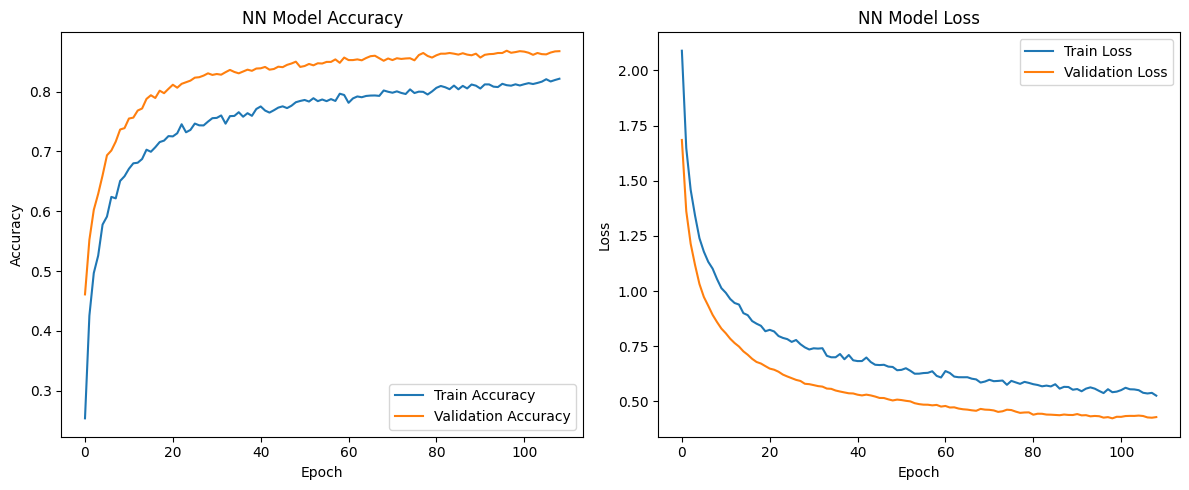

In [29]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(NN_history.history['accuracy'], label='Train Accuracy')
plt.plot(NN_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('NN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(NN_history.history['loss'], label='Train Loss')
plt.plot(NN_history.history['val_loss'], label='Validation Loss')
plt.title('NN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
from tensorflow.keras.models import load_model

model = load_model('mfcc_nn_best_model.keras')


In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import time

start_time = time.time()

y_pred = model.predict(X_test_flat)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.4f} seconds")

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Inference time: 0.2988 seconds
Accuracy: 0.87
F1 Score: 0.87


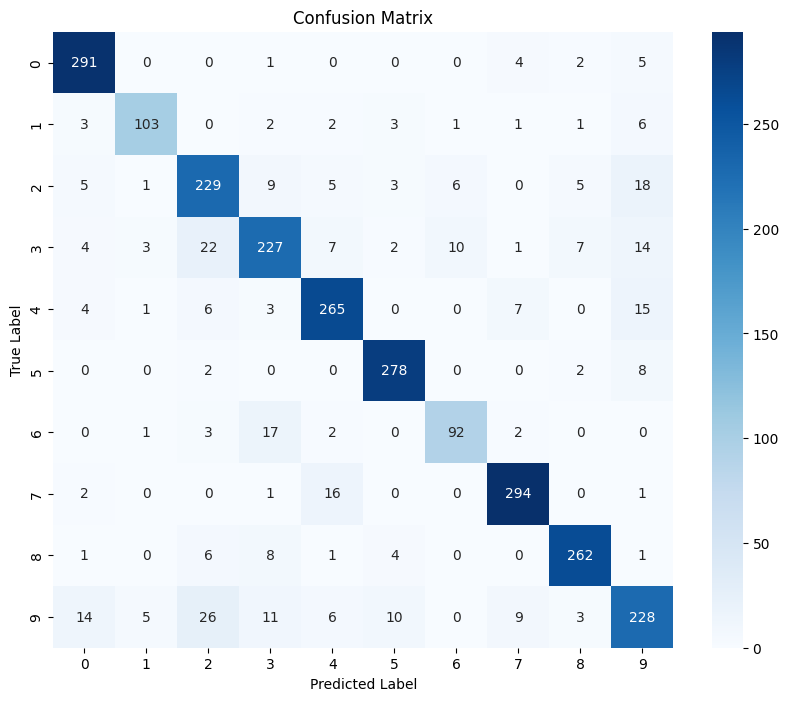

In [32]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [33]:
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       0.90      0.96      0.93       303
           1       0.90      0.84      0.87       122
           2       0.78      0.81      0.80       281
           3       0.81      0.76      0.79       297
           4       0.87      0.88      0.88       301
           5       0.93      0.96      0.94       290
           6       0.84      0.79      0.81       117
           7       0.92      0.94      0.93       314
           8       0.93      0.93      0.93       283
           9       0.77      0.73      0.75       312

    accuracy                           0.87      2620
   macro avg       0.87      0.86      0.86      2620
weighted avg       0.87      0.87      0.87      2620



In [34]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

from itertools import cycle


In [35]:

n_classes = len(np.unique(y_true))
y_test_binarized = label_binarize(y_test, classes=range(n_classes))


In [36]:
class_names = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]

In [37]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


print("AUC-ROC Scores by class:")
for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.2f}")
print(f"Micro-average AUC-ROC: {roc_auc['micro']:.2f}")

AUC-ROC Scores by class:
air_conditioner: 1.00
car_horn: 0.99
children_playing: 0.98
dog_bark: 0.98
drilling: 0.99
engine_idling: 1.00
gun_shot: 0.99
jackhammer: 1.00
siren: 0.99
street_music: 0.96
Micro-average AUC-ROC: 0.99


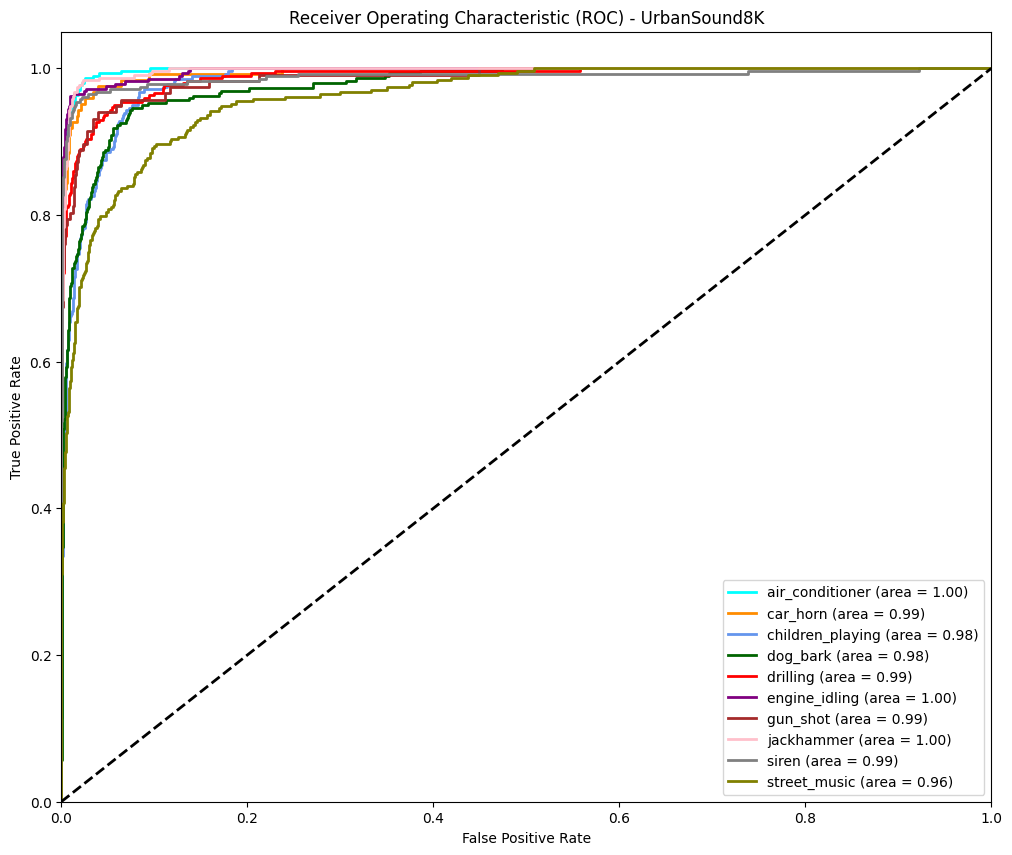

In [38]:

plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - UrbanSound8K')
plt.legend(loc="lower right")
plt.show()


CNN

In [39]:
def create_model(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.5),
        Conv1D(128, 3, activation='relu'),
        Conv1D(128, 3, activation='relu'),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(y_train.shape[1], activation='softmax')  
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [40]:

checkpoint_path = "mfcc_best_model.keras"


checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')


In [41]:

input_shape = (X_train.shape[1], 1)


CNNmodel = create_model(input_shape)

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
CNNmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 36, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 16, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 14, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,882 (343.29 KB)

 Trainable params: 87,882 (343.29 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:

CNNhistory = CNNmodel.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])


Epoch 1/200
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1606 - loss: 2.2212
Epoch 1: val_accuracy improved from -inf to 0.27061, saving model to mfcc_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1614 - loss: 2.2198 - val_accuracy: 0.2706 - val_loss: 2.0096
Epoch 2/200
184/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2551 - loss: 2.0262
Epoch 2: val_accuracy improved from 0.27061 to 0.31450, saving model to mfcc_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2556 - loss: 2.0250 - val_accuracy: 0.3145 - val_loss: 1.8825
Epoch 3/200
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2895 - loss: 1.9052
Epoch 3: val_accuracy improved from 0.31450 to 0.40229, saving model to mfcc_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2898 - loss: 1.9051 - val_accuracy: 0.4023 - val_loss: 1.7857
Epoch 4/200
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3288 - loss: 1.8389
Epoch 4: val_accur

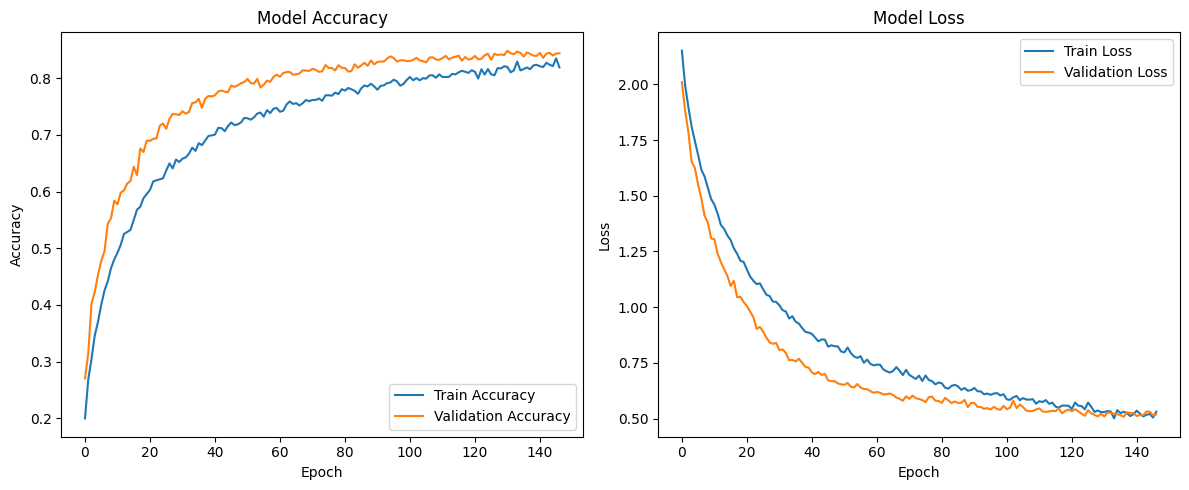

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(CNNhistory.history['accuracy'], label='Train Accuracy')
plt.plot(CNNhistory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(CNNhistory.history['loss'], label='Train Loss')
plt.plot(CNNhistory.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
from tensorflow.keras.models import load_model

model = load_model('mfcc - best_model.keras')


In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import time

start_time = time.time()

y_pred = model.predict(X_test)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.4f} seconds")

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Inference time: 0.8629 seconds
Accuracy: 0.83
F1 Score: 0.83


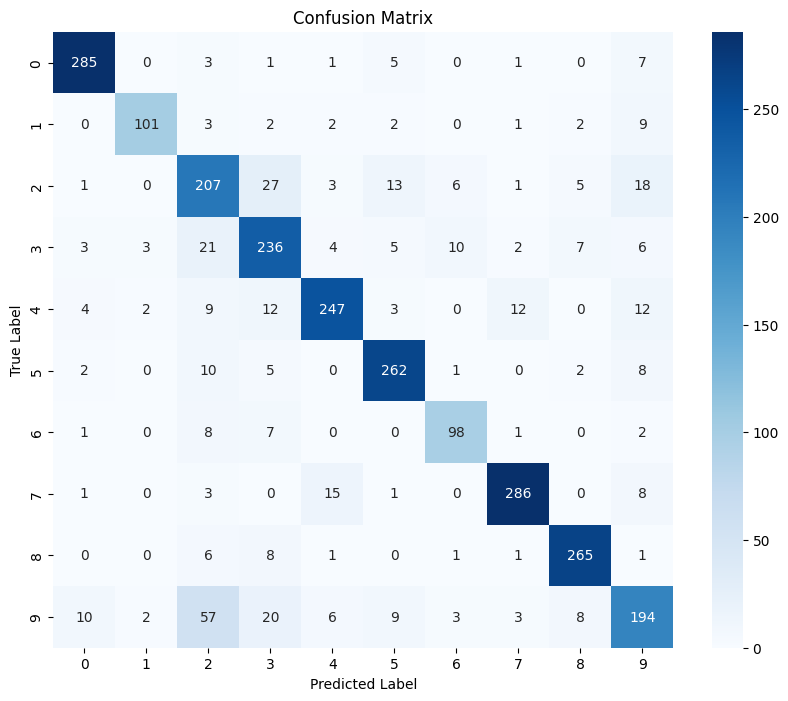

In [47]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [48]:
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       0.93      0.94      0.93       303
           1       0.94      0.83      0.88       122
           2       0.63      0.74      0.68       281
           3       0.74      0.79      0.77       297
           4       0.89      0.82      0.85       301
           5       0.87      0.90      0.89       290
           6       0.82      0.84      0.83       117
           7       0.93      0.91      0.92       314
           8       0.92      0.94      0.93       283
           9       0.73      0.62      0.67       312

    accuracy                           0.83      2620
   macro avg       0.84      0.83      0.84      2620
weighted avg       0.84      0.83      0.83      2620



In [49]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

from itertools import cycle


In [50]:

n_classes = len(np.unique(y_true))
y_test_binarized = label_binarize(y_test, classes=range(n_classes))


In [51]:
class_names = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]

In [52]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


print("AUC-ROC Scores by class:")
for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.2f}")
print(f"Micro-average AUC-ROC: {roc_auc['micro']:.2f}")

AUC-ROC Scores by class:
air_conditioner: 0.99
car_horn: 0.99
children_playing: 0.96
dog_bark: 0.97
drilling: 0.98
engine_idling: 0.99
gun_shot: 0.98
jackhammer: 1.00
siren: 0.99
street_music: 0.95
Micro-average AUC-ROC: 0.98


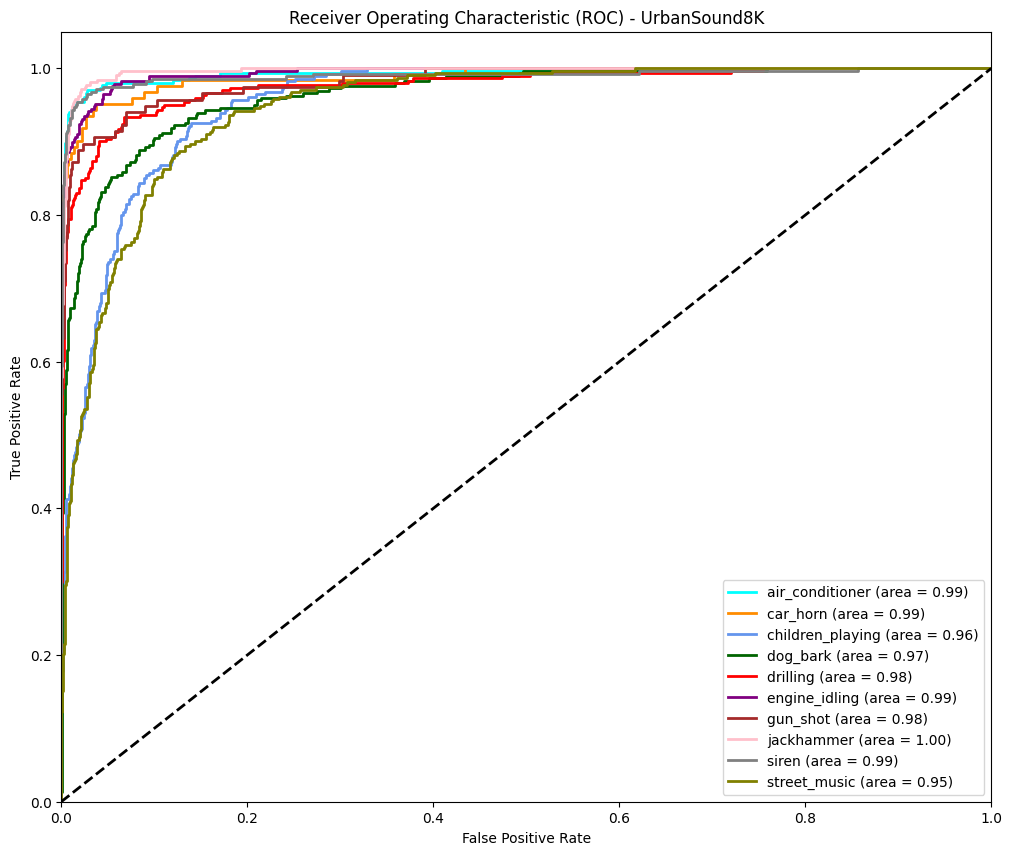

In [53]:

plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - UrbanSound8K')
plt.legend(loc="lower right")
plt.show()
